In [95]:
!pip install reverse_geocoder

In [96]:
import xarray as xr
import pandas as pd
import numpy as np
from google.colab import drive
import os

drive.mount('/content/drive')

nc_path = '/content/drive/Shareddrives/File Project Data Wrangling/CDR_1084_2025-11-09022621am.nc'
csv_output_labeled = "/content/Curah Hujan.csv"

os.makedirs(os.path.dirname(csv_output_labeled), exist_ok=True)

var_name = "precip"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [97]:
ds = xr.open_dataset(nc_path)
da = ds[var_name]

In [98]:
df = da.to_dataframe().reset_index()
df.head(100)

,datetime,lat,lon,precip
0,2022-01-01,-5.25,110.75,-99.0
1,2022-01-01,-5.25,111.00,-99.0
2,2022-01-01,-5.25,111.25,-99.0
3,2022-01-01,-5.25,111.50,-99.0
4,2022-01-01,-5.25,111.75,-99.0
...,...,...,...,...
95,2022-01-01,-6.25,112.50,-99.0
96,2022-01-01,-6.25,112.75,-99.0
97,2022-01-01,-6.25,113.00,-99.0
98,2022-01-01,-6.25,113.25,-99.0


In [99]:
df[var_name] = df[var_name].replace(-99.0, np.nan)
df_clean = df.dropna(subset=[var_name]).copy()
df_clean['datetime'] = pd.to_datetime(df_clean['datetime'])

print(f"Jumlah baris sebelum cleaning: {len(df)}")
print(f"Jumlah baris setelah cleaning: {len(df_clean)}")
df_clean.head()

Jumlah baris sebelum cleaning: 11880
Jumlah baris setelah cleaning: 2268


,datetime,lat,lon,precip
135,2022-01-01,-6.75,111.50,268.278015
136,2022-01-01,-6.75,111.75,281.283508
138,2022-01-01,-6.75,112.25,289.568909
144,2022-01-01,-6.75,113.75,294.995117
150,2022-01-01,-6.75,115.25,252.023651


In [100]:
import reverse_geocoder as rg

unique_coords = df_clean[['lat', 'lon']].drop_duplicates()
coords_tuple = list(zip(unique_coords['lat'], unique_coords['lon']))

results = rg.search(coords_tuple)

def get_location_name(result):
    kab = result.get('admin2', '')
    if not kab:
        kab = result.get('name', '')

    return kab

unique_coords['Kabupaten'] = [get_location_name(res) for res in results]
unique_coords['Provinsi'] = [res['admin1'] for res in results]

print(unique_coords[['lat', 'lon', 'Kabupaten', 'Provinsi']].head(10))

unique_coords_jatim = unique_coords[
    (unique_coords['Provinsi'] == 'East Java') |
    (unique_coords['Provinsi'] == '')
].copy()

df_mapped = pd.merge(df_clean, unique_coords_jatim, on=['lat', 'lon'], how='inner')

print("Daftar Kota yang terdeteksi:", df_mapped['Kabupaten'].unique())
print(df_mapped[['datetime', 'Kabupaten', var_name]].head())

      lat     lon    Kabupaten      Provinsi
135 -6.75  111.50    Sidowayah  Central Java
136 -6.75  111.75      Boncong     East Java
138 -6.75  112.25  Sedayulawas     East Java
144 -6.75  113.75       Campor     East Java
150 -6.75  115.25   Gerelayang     East Java
157 -7.00  111.50      Klampok  Central Java
158 -7.00  111.75      Sendang     East Java
159 -7.00  112.00      Gesikan     East Java
160 -7.00  112.25       Jabung     East Java
161 -7.00  112.50     Kalimati     East Java
Daftar Kota yang terdeteksi: ['Boncong' 'Sedayulawas' 'Campor' 'Gerelayang' 'Sendang' 'Gesikan'
 'Jabung' 'Kalimati' 'Timurembong' 'Mandepa Barat' 'Derbing'
 'Trebungonjur' 'Palampal' 'Sokarame' 'Mojosawit' 'Bojonegoro' 'Babat'
 'Bendungan' 'Nganjuk' 'Kertosono' 'Jombang' 'Mojokerto' 'Kedungpeluk'
 'Madiun' 'Gampengrejo' 'Pare' 'Batu' 'Lawang' 'Pasuruan' 'Probolinggo'
 'Krajan Alastengah' 'Besuki' 'Sliwungkrajan' 'Randuagung' 'Ploso'
 'Krajan Tengah' 'Bibis' 'Jujur' 'Temenggungan' 'Ringinrejo' 'Wonos

In [101]:
!pip install geopy

import pandas as pd
import time
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

unique_coords = df_clean[['lat', 'lon']].drop_duplicates().reset_index(drop=True)

print(f"Titik koordinat unik:{len(unique_coords)}")

geolocator = Nominatim(user_agent="project_skripsi_jatim_mahasiswa")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

def get_kabupaten_online(lat, lon):
    try:
        location = geolocator.reverse(f"{lat}, {lon}", language='id', exactly_one=True)

        if location and location.raw.get('address'):
            address = location.raw['address']

            kab = address.get('city') or address.get('county') or address.get('district')
            prov = address.get('state')

            return kab, prov

    except Exception as e:
        print(f"Error pada {lat}, {lon}: {e}")
        return None, None

    return None, None

list_kab = []
list_prov = []

print("Mengambil data nama kota dari server.")

for index, row in unique_coords.iterrows():
    kab, prov = get_kabupaten_online(row['lat'], row['lon'])

    if index % 10 == 0:
        print(f"Proses titik ke-{index}: {kab}, {prov}")

    list_kab.append(kab)
    list_prov.append(prov)

unique_coords['Kabupaten'] = list_kab
unique_coords['Provinsi'] = list_prov

def rapikan_nama(nama):
    if pd.isna(nama): return "Tidak Terdeteksi"
    nama = str(nama)
    if not (nama.startswith('Kabupaten') or nama.startswith('Kota')):
        pass
    return nama

unique_coords['Kabupaten'] = unique_coords['Kabupaten'].apply(rapikan_nama)
unique_coords_jatim = unique_coords[unique_coords['Provinsi'] == 'Jawa Timur'].copy()

df_mapped = pd.merge(df_clean, unique_coords_jatim, on=['lat', 'lon'], how='inner')

print(df_mapped['Kabupaten'].unique())
print(df_mapped[['datetime', 'Kabupaten', var_name]].head())

Titik koordinat unik:63
Mengambil data nama kota dari server.
Proses titik ke-0: Rembang, Jawa Tengah


Proses titik ke-10: Bangkalan, Jawa Timur
Proses titik ke-20: Lamongan, Jawa Timur


Proses titik ke-30: Madiun, Jawa Timur


Proses titik ke-40: None, Jawa Timur


Proses titik ke-50: Lumajang, Jawa Timur


Proses titik ke-60: Banyuwangi, Jawa Timur
['Tuban' 'Tidak Terdeteksi' 'Lamongan' 'Gresik' 'Bangkalan' 'Sampang'
 'Sumenep' 'Bojonegoro' 'Madiun' 'Nganjuk' 'Jombang' 'Mojokerto'
 'Sidoarjo' 'Kabupaten Kediri' 'Gumeng' 'Pasuruan' 'Probolinggo' 'Pacitan'
 'Ponorogo' 'Trenggalek' 'Blitar' 'Kabupaten Malang' 'Lumajang'
 'Bondowoso' 'Banyuwangi' 'Jember']
    datetime         Kabupaten      precip
0 2022-01-01             Tuban  281.283508
1 2022-01-01  Tidak Terdeteksi  289.568909
2 2022-01-01  Tidak Terdeteksi  294.995117
3 2022-01-01  Tidak Terdeteksi  252.023651
4 2022-01-01             Tuban  279.927307


In [102]:
df = df_mapped
df = df[df['precip'] > 0].copy()
corrections = {
    (-6.75, 112.25): 'Lamongan',
    (-6.75, 113.75): 'Sumenep',
    (-6.75, 115.25): 'Sumenep',
    (-7.00, 113.50): 'Pamekasan',
    (-7.00, 114.25): 'Sumenep',
    (-7.50, 111.25): 'Ngawi',
    (-7.50, 111.50): 'Madiun',
    (-7.75, 113.75): 'Situbondo',
    (-7.75, 114.25): 'Situbondo',
    (-7.75, 114.0): 'Situbondo',
    (-7.75, 114.00): 'Situbondo',
    (-7.75, 112.50): 'Mojokerto',
}

def apply_manual_fix(row):
    coord_rounded = (round(row['lat'], 2), round(row['lon'], 2))
    if coord_rounded in corrections:
        return corrections[coord_rounded]
    return row['Kabupaten']

df['Kabupaten'] = df.apply(apply_manual_fix, axis=1)

def clean_name_only(name):
    name = str(name).strip()
    name = name.replace('Kabupaten ', '').replace('kabupaten ', '')
    name = name.replace('Kota ', '').replace('kota ', '')

    return name.strip()

df['Kabupaten'] = df['Kabupaten'].apply(clean_name_only)
print(df['Kabupaten'].unique())

df.head(5)

['Tuban' 'Lamongan' 'Sumenep' 'Gresik' 'Bangkalan' 'Sampang' 'Pamekasan'
 'Bojonegoro' 'Ngawi' 'Madiun' 'Nganjuk' 'Jombang' 'Mojokerto' 'Sidoarjo'
 'Kediri' 'Pasuruan' 'Probolinggo' 'Situbondo' 'Pacitan' 'Ponorogo'
 'Trenggalek' 'Blitar' 'Malang' 'Lumajang' 'Bondowoso' 'Banyuwangi'
 'Jember']


,datetime,lat,lon,precip,Kabupaten,Provinsi
0,2022-01-01,-6.75,111.75,281.283508,Tuban,Jawa Timur
1,2022-01-01,-6.75,112.25,289.568909,Lamongan,Jawa Timur
2,2022-01-01,-6.75,113.75,294.995117,Sumenep,Jawa Timur
3,2022-01-01,-6.75,115.25,252.023651,Sumenep,Jawa Timur
4,2022-01-01,-7.00,111.75,279.927307,Tuban,Jawa Timur


In [103]:
df['datetime'] = pd.to_datetime(df['datetime'])
df['Tahun'] = df['datetime'].dt.year

df_harian = df.groupby(['Kabupaten', 'Tahun', 'datetime'])['precip'].mean().reset_index()

df_tahunan = df_harian.groupby(['Kabupaten', 'Tahun'])['precip'].sum().reset_index()

df_tahunan.columns = ['Kabupaten', 'Tahun', 'Total Curah Hujan (mm)']

print(df_tahunan.head(100))
print(f"Total Baris Data: {len(df_tahunan)}")

df_tahunan.to_csv('Data_Curah_Hujan_2022_2024.csv', index=False)

     Kabupaten  Tahun  Total Curah Hujan (mm)
0    Bangkalan   2022             2590.166504
1    Bangkalan   2023             1600.556152
2    Bangkalan   2024             2138.270996
3   Banyuwangi   2022             1958.069092
4   Banyuwangi   2023             1302.630737
..         ...    ...                     ...
76  Trenggalek   2023             1744.210815
77  Trenggalek   2024             2676.196045
78       Tuban   2022             2574.358154
79       Tuban   2023             1624.017456
80       Tuban   2024             2460.468750

[81 rows x 3 columns]
Total Baris Data: 81


Produksi Padi

In [104]:
import pandas as pd

df_2022 = pd.read_csv("/content/drive/Shareddrives/File Project Data Wrangling/Produksi Padi Jawa Timur 2022.csv")
df_2023 = pd.read_csv("/content/drive/Shareddrives/File Project Data Wrangling/Produksi Padi Jawa Timur 2023.csv")
df_2024 = pd.read_csv("/content/drive/Shareddrives/File Project Data Wrangling/Produksi Padi Jawa Timur 2024.csv")

df_2022 = df_2022[['Kabupaten/Kota', 'Produksi Padi - Produksi Padi (ton) (Ton)']]
df_2023 = df_2023[['Kabupaten/Kota', 'Produksi Padi - Produksi Padi (ton) (Ton)']]
df_2024 = df_2024[['Kabupaten/Kota', 'Produksi Padi - Produksi Padi (ton) (Ton)']]

df_2022['Tahun'] = 2022
df_2023['Tahun'] = 2023
df_2024['Tahun'] = 2024

df_all = pd.concat([df_2022, df_2023, df_2024], ignore_index=True)

df_all.to_csv("Produksi_Padi_2022_2024.csv", index=False)

print(df_all.head(100))

   Kabupaten/Kota  Produksi Padi - Produksi Padi (ton) (Ton)  Tahun
0         Pacitan                                   90428.21   2022
1        Ponorogo                                  359413.77   2022
2      Trenggalek                                  115758.01   2022
3     Tulungagung                                  207217.26   2022
4          Blitar                                  215482.79   2022
..            ...                                        ...    ...
95        Magetan                                  272246.05   2024
96          Ngawi                                  765703.53   2024
97     Bojonegoro                                  710527.18   2024
98          Tuban                                  523067.49   2024
99       Lamongan                                  776290.66   2024

[100 rows x 3 columns]


Harga Beras

In [105]:
import pandas as pd

df_2022 = pd.read_csv("/content/drive/Shareddrives/File Project Data Wrangling/harga beras jatim 2022.csv")
df_2023 = pd.read_csv("/content/drive/Shareddrives/File Project Data Wrangling/harga beras jatim 2023.csv")
df_2024 = pd.read_csv("/content/drive/Shareddrives/File Project Data Wrangling/harga beras jatim 2024.csv")

df_2022 = df_2022[['Kabupaten/Kota', 'Harga Beras (Rp)']]
df_2023 = df_2023[['Kabupaten/Kota', 'Harga Beras (Rp)']]
df_2024 = df_2024[['Kabupaten/Kota', 'Harga Beras (Rp)']]

df_2022['Tahun'] = 2022
df_2023['Tahun'] = 2023
df_2024['Tahun'] = 2024

df_all = pd.concat([df_2022, df_2023, df_2024], ignore_index=True)

df_all.to_csv("Harga_Beras_2022_2024.csv", index=False)

print(df_all.head(100))

        Kabupaten/Kota Harga Beras (Rp)  Tahun
0          Kota Blitar         Rp11.750   2022
1        Kota Pasuruan         Rp11.500   2022
2   Kabupaten Sidoarjo         Rp11.500   2022
3     Kabupaten Malang         Rp11.400   2022
4            Kota Batu         Rp11.075   2022
..                 ...              ...    ...
95  Kabupaten Lamongan         Rp12.250   2024
96    Kota Probolinggo         Rp12.166   2024
97     Kabupaten Ngawi         Rp12.166   2024
98   Kabupaten Jombang         Rp12.166   2024
99    Kabupaten Gresik         Rp12.166   2024

[100 rows x 3 columns]


In [110]:
df_hujan = pd.read_csv("Data_Curah_Hujan_2022_2024.csv")
df_padi = pd.read_csv("Produksi_Padi_2022_2024.csv")
df_harga = pd.read_csv("Harga_Beras_2022_2024.csv")

def bersihkan_nama(nama):
    nama = str(nama).strip()
    nama = nama.replace('Kabupaten ', '').replace('kabupaten ', '')
    nama = nama.replace('Kota ', '').replace('kota ', '')
    return nama.strip().title()

def bersihkan_angka_rupiah(nilai):
    nilai = str(nilai)
    nilai = nilai.replace('Rp', '').replace('rp', '').replace(' ', '')
    nilai = nilai.replace('.', '')
    nilai = nilai.replace(',', '.')
    try:
        return float(nilai)
    except:
        return np.nan

df_hujan['Kabupaten'] = df_hujan['Kabupaten'].apply(bersihkan_nama)
df_padi = df_padi.rename(columns={'Kabupaten/Kota': 'Kabupaten'})
df_padi['Kabupaten'] = df_padi['Kabupaten'].apply(bersihkan_nama)
df_harga = df_harga.rename(columns={'Kabupaten/Kota': 'Kabupaten'})
df_harga['Kabupaten'] = df_harga['Kabupaten'].apply(bersihkan_nama)

col_harga = 'Harga Beras (Rp)'
df_harga[col_harga] = df_harga[col_harga].apply(bersihkan_angka_rupiah)

col_padi = 'Produksi Padi - Produksi Padi (ton) (Ton)'
df_padi[col_padi] = df_padi[col_padi].apply(bersihkan_angka_rupiah)

df_padi_fix = df_padi.groupby(['Kabupaten', 'Tahun'])[col_padi].sum().reset_index()
df_padi_fix.rename(columns={col_padi: 'Produksi Padi (Ton)'}, inplace=True)

df_harga_fix = df_harga.dropna(subset=[col_harga]).groupby(['Kabupaten', 'Tahun'])[col_harga].mean().reset_index()
df_harga_fix.rename(columns={col_harga: 'Harga Beras (Rp)'}, inplace=True)

df_hujan_fix = df_hujan.groupby(['Kabupaten', 'Tahun'])['Total Curah Hujan (mm)'].mean().reset_index()


df_merge_1 = pd.merge(df_hujan_fix, df_padi_fix, on=['Kabupaten', 'Tahun'], how='inner')
df_final_master = pd.merge(df_merge_1, df_harga_fix, on=['Kabupaten', 'Tahun'], how='inner')

print(f"Jumlah Baris Akhir: {len(df_final_master)}")
print(df_final_master.head(10))
df_final_master.to_csv("Dataset Final.csv", index=False)

Jumlah Baris Akhir: 81
    Kabupaten  Tahun  Total Curah Hujan (mm)  Produksi Padi (Ton)  \
0   Bangkalan   2022               2590.1665           19812271.0   
1   Bangkalan   2023               1600.5562           18625796.0   
2   Bangkalan   2024               2138.2710            1891619.0   
3  Banyuwangi   2022               1958.0691           46220598.0   
4  Banyuwangi   2023               1302.6307           45476846.0   
5  Banyuwangi   2024               1533.2368           39563138.0   
6      Blitar   2022               2565.9788           22069492.0   
7      Blitar   2023               1704.7554           24586109.0   
8      Blitar   2024               2647.1800           17487619.0   
9  Bojonegoro   2022               2879.3662           70428894.0   

   Harga Beras (Rp)  
0           11000.0  
1           11000.0  
2           11000.0  
3           10680.0  
4           10900.0  
5           12160.0  
6           11125.0  
7           11512.5  
8           11950.0

In [123]:
print("Statistik Deskriptif Jawa timur Pertahun")
print(df[['Total Curah Hujan (mm)', 'Produksi Padi (Ton)', 'Harga Beras (Rp)']].describe())

print("\n5 Kabupaten dengan Curah Hujan Tertinggi")
top_hujan = df.groupby('Kabupaten')['Total Curah Hujan (mm)'].mean().sort_values(ascending=False).head(5)
print(top_hujan)

print("\n5 Kabupaten dengan Harga Beras Termahal")
top_harga = df.groupby('Kabupaten')['Harga Beras (Rp)'].mean().sort_values(ascending=False).head(5)
print(top_harga)

Statistik Deskriptif Jawa timur Pertahun
       Total Curah Hujan (mm)  Produksi Padi (Ton)  Harga Beras (Rp)
count               81.000000         8.100000e+01         81.000000
mean              2166.560054         3.206168e+07      11312.444444
std                474.478545         2.113260e+07        888.846071
min               1196.135300         1.416280e+06       9500.000000
25%               1726.633800         1.748762e+07      10883.000000
50%               2228.140600         2.680820e+07      11400.000000
75%               2580.103000         4.174286e+07      12083.000000
max               2883.515400         9.038823e+07      12833.000000

5 Kabupaten dengan Curah Hujan Tertinggi
Kabupaten
Bojonegoro    2576.613300
Ngawi         2536.799267
Madiun        2522.778867
Jombang       2506.258333
Nganjuk       2493.753367
Name: Total Curah Hujan (mm), dtype: float64

5 Kabupaten dengan Harga Beras Termahal
Kabupaten
Sidoarjo      11650.000000
Kediri        11572.000000
Pasuru

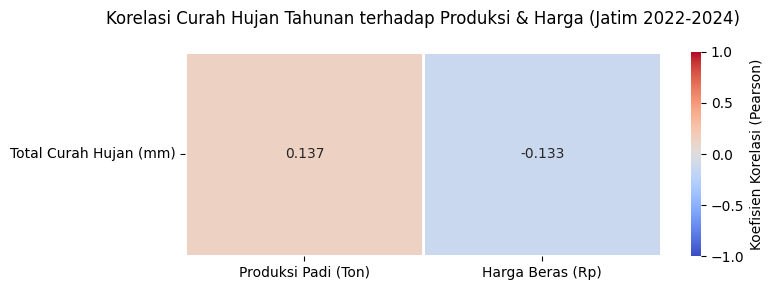

In [116]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


cols_analisis = ['Total Curah Hujan (mm)', 'Produksi Padi (Ton)', 'Harga Beras (Rp)']
corr_matrix = df[cols_analisis].corr()

target_var = 'Total Curah Hujan (mm)'
other_vars = ['Produksi Padi (Ton)', 'Harga Beras (Rp)']
filtered_corr = corr_matrix.loc[[target_var], other_vars]

plt.figure(figsize=(8, 3))
sns.heatmap(
    filtered_corr,
    annot=True,
    cmap='coolwarm',
    vmin=-1, vmax=1,
    fmt=".3f",
    linewidths=1,
    cbar_kws={"label": "Koefisien Korelasi (Pearson)"}
)
plt.title('Korelasi Curah Hujan Tahunan terhadap Produksi & Harga (Jatim 2022-2024)', fontsize=12, pad=20)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

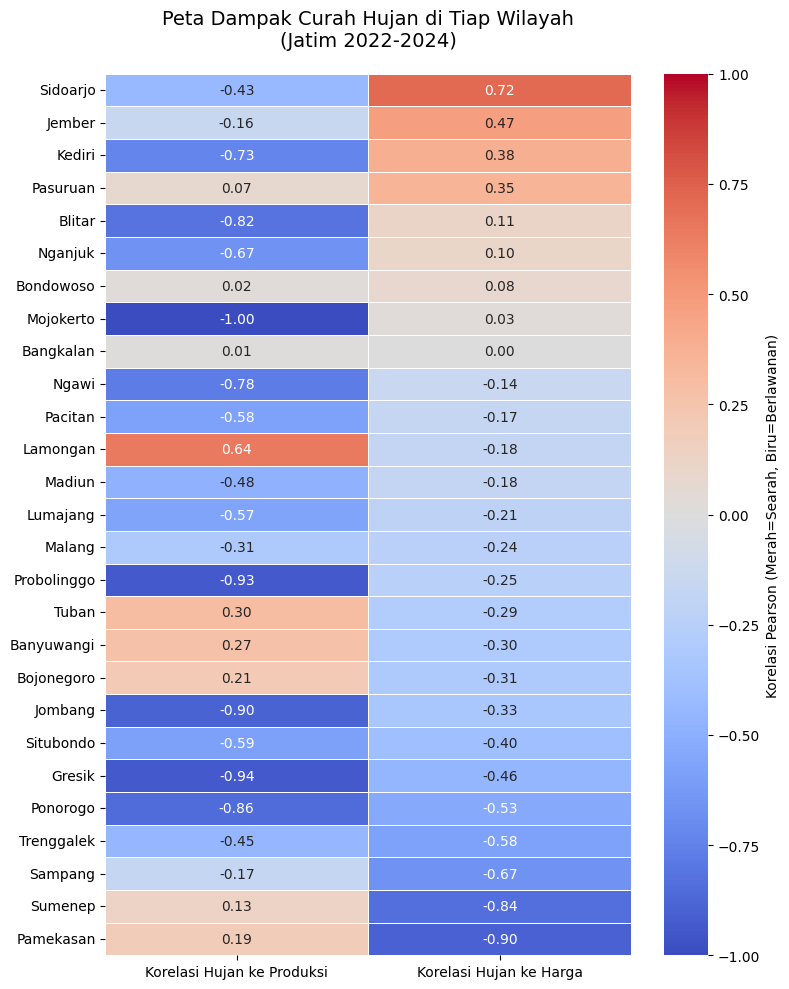

In [121]:
list_kabupaten = df['Kabupaten'].unique()
data_heatmap = []

col_hujan = 'Total Curah Hujan (mm)'
col_produksi = 'Produksi Padi (Ton)'
col_harga = 'Harga Beras (Rp)'

for kota in list_kabupaten:
    df_kota = df[df['Kabupaten'] == kota]

    if len(df_kota) >= 3:
        corr_mat = df_kota[[col_hujan, col_produksi, col_harga]].corr()
        r_produksi = corr_mat.loc[col_hujan, col_produksi]
        r_harga = corr_mat.loc[col_hujan, col_harga]

        data_heatmap.append({
            'Kabupaten': kota,
            'Korelasi Hujan ke Produksi': r_produksi,
            'Korelasi Hujan ke Harga': r_harga
        })

df_corr_wilayah = pd.DataFrame(data_heatmap)

df_corr_wilayah = df_corr_wilayah.set_index('Kabupaten')
df_corr_wilayah = df_corr_wilayah.fillna(0)
df_corr_wilayah = df_corr_wilayah.sort_values(by='Korelasi Hujan ke Harga', ascending=False)

plt.figure(figsize=(8, 10))

sns.heatmap(
    df_corr_wilayah,
    annot=True,
    cmap='coolwarm',
    vmin=-1, vmax=1,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"label": "Korelasi Pearson (Merah=Searah, Biru=Berlawanan)"}
)
plt.title('Peta Dampak Curah Hujan di Tiap Wilayah\n(Jatim 2022-2024)', fontsize=14, pad=20)
plt.ylabel('')
plt.tight_layout()
plt.show()

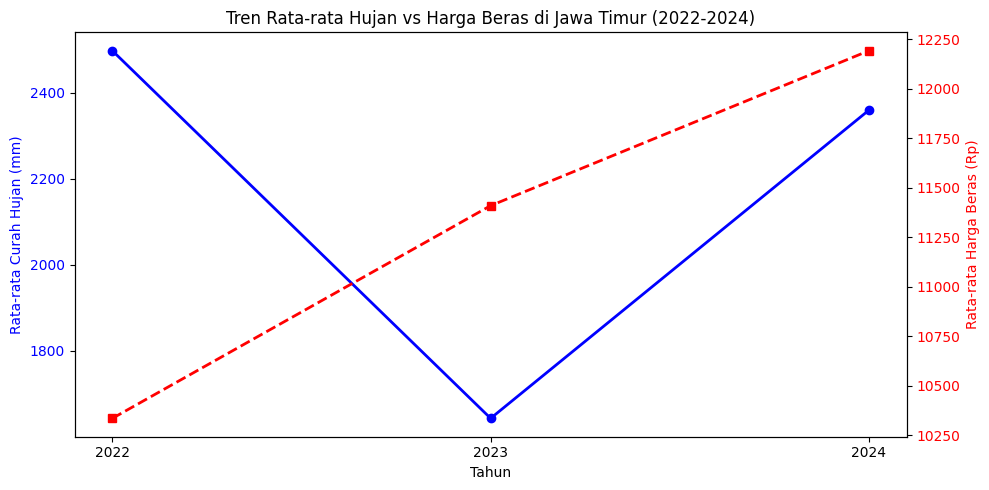

In [125]:
df_trend = df.groupby('Tahun')[['Total Curah Hujan (mm)', 'Produksi Padi (Ton)', 'Harga Beras (Rp)']].mean().reset_index()

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel('Tahun')
ax1.set_ylabel('Rata-rata Curah Hujan (mm)', color='blue')
ax1.plot(df_trend['Tahun'], df_trend['Total Curah Hujan (mm)'], color='blue', marker='o', linewidth=2, label='Curah Hujan')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks([2022, 2023, 2024])

ax2 = ax1.twinx()
ax2.set_ylabel('Rata-rata Harga Beras (Rp)', color='red')
ax2.plot(df_trend['Tahun'], df_trend['Harga Beras (Rp)'], color='red', marker='s', linestyle='--', linewidth=2, label='Harga Beras')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Tren Rata-rata Hujan vs Harga Beras di Jawa Timur (2022-2024)')
fig.tight_layout()
plt.show()

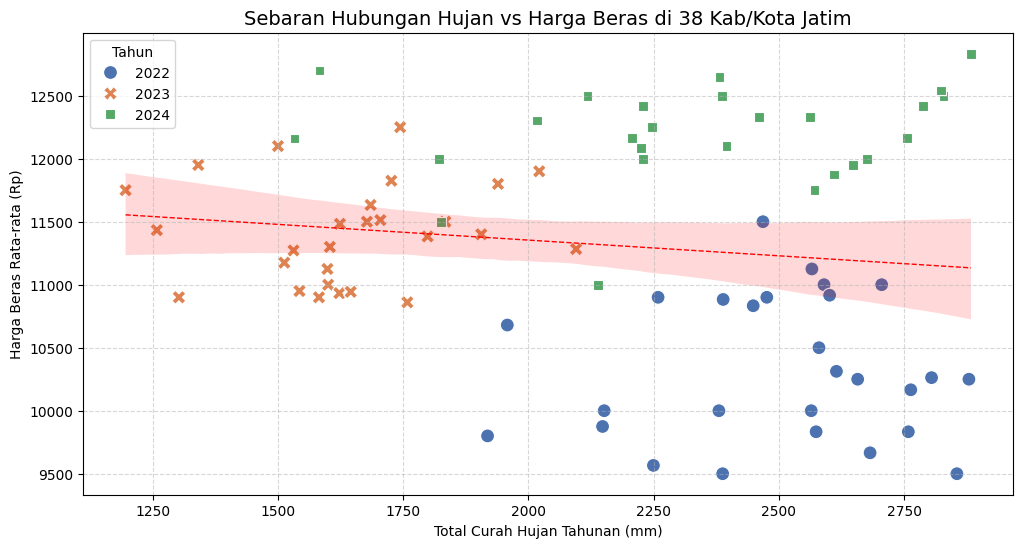

In [117]:
plt.figure(figsize=(12, 6))

sns.scatterplot(
    data=df,
    x='Total Curah Hujan (mm)',
    y='Harga Beras (Rp)',
    hue='Tahun',
    style='Tahun',
    palette='deep',
    s=100
)

sns.regplot(
    data=df,
    x='Total Curah Hujan (mm)',
    y='Harga Beras (Rp)',
    scatter=False,
    color='red',
    line_kws={"linewidth": 1, "linestyle": "--"}
)

plt.title('Sebaran Hubungan Hujan vs Harga Beras di 38 Kab/Kota Jatim', fontsize=14)
plt.xlabel('Total Curah Hujan Tahunan (mm)')
plt.ylabel('Harga Beras Rata-rata (Rp)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()